In [83]:
import os
from pathlib import Path
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tqdm import tqdm 
from matplotlib.lines import Line2D
from concurrent.futures import ProcessPoolExecutor, as_completed
from multiprocessing import Pool, cpu_count
from sklearn.preprocessing import StandardScaler



In [84]:
def bin_spikes(spike_times, end_time, bin_size):
    """
    Bins spike events into a time series.

    Args:
        spike_times: A 1D numpy array of spike timestamps.
        end_time: The end time of the recording.
        bin_size: The desired time bin size.

    Returns:
        A tuple containing:
            - binned_spikes: A 1D numpy array where each element is the count of spikes in the corresponding time bin.
            - spike_rates: A 1D numpy array of firing rate (spikes per unit time) for each bin.
            - bin_centers: A 1D numpy array of the center timestamp for each bin.
    """
    # Calculate the number of bins
    num_bins = int(np.ceil(end_time / bin_size))
    
    # Create the time bins
    bins = np.linspace(0, end_time, num_bins + 1)

    # Count spikes in each bin
    binned_spikes, bin_edges = np.histogram(spike_times, bins=bins)
    
    # Convert counts to spike rates
    spike_rates = binned_spikes / bin_size

    # Get bin centers
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    return binned_spikes, spike_rates, bin_centers

#ignore start time # use swecp
def update_stim_eps_end_time(df_visualstim_path,stim_ep):
    df_interest = df_visualstim_path[df_visualstim_path['stim_name']==stim_ep] 
    df_interest = df_interest.reset_index()
    stop_times = list(df_interest['start_time'][1:])
    # getting rid of last trial, the accuracy seems to much to deal with 
    df_interest = df_interest[:-1]
    df_interest['stop_time'] = stop_times
    return df_interest

def filter_with_numpy(data_array, start_time, stop_time):
  """
  Filters a NumPy array using fast boolean indexing and subtracts the
  start time from the results.
  """
  # Create a boolean "mask" in a single, fast operation
  mask = (data_array >= start_time) & (data_array <= stop_time)

  # Apply the mask to get the filtered results
  filtered_array = data_array[mask]

  # Check if the resulting array is not empty before subtracting
  if filtered_array.size > 0:
    return filtered_array - start_time
  else:
    return filtered_array # Return the empty array as is

def init_worker(spikes_data):
    """
    Initializes each worker process with a global copy of the spikes data.
    """
    # Declare a global variable inside the worker's scope
    global worker_spikes
    worker_spikes = spikes_data

# --- Step 2: Create the worker function for a single trial ---
# This function now assumes 'worker_spikes' exists globally in its process.
def process_trial_spiketimes(trial_info):
    """
    Processes a single trial using the pre-loaded global spikes data.
    """
    # Unpack the arguments (note: 'all_spikes' is no longer passed in)
    trial_index, start_time, stop_time, output_path = trial_info
    
    try:
        duration = stop_time - start_time
        
        # Access the global spikes data. No data is passed for each task!
        filtered_spikes = [filter_with_numpy(neuron_spikes, start_time, stop_time) for neuron_spikes in worker_spikes]
        filtered_spikes.append(duration)
        
        filename = os.path.join(output_path, f'trial_array_{trial_index}.pkl')
        with open(filename, 'wb') as f:
            pickle.dump(filtered_spikes, f)
        return None # Return nothing for success
    except Exception as e:
        return f"Error in trial {trial_index}: {e}" # Return error message

# --- Step 3: Modify your main function to use multiprocessing.Pool ---
def extract_spikes_times_parallel_optimized(df_interest, stim_ep, main_path):
    stim_ep_path = os.path.join(main_path, stim_ep,'raw')
    if not os.path.exists(stim_ep_path):
        os.makedirs(stim_ep_path)
    # This is the large, read-only data
    spikes_data = df_data[f"{stim_ep}_spikes"].values

    # Prepare the list of tasks. Each task now contains only the small, per-trial data.
    tasks = []
    for i in range(len(df_interest)):
        row = df_interest.iloc[i]
        tasks.append((i, row['start_time'], row['stop_time'], stim_ep_path))
    # Use the Pool to manage worker processes
    # initializer=init_worker: The function to run when each worker starts.
    # initargs=(spikes_data,): The arguments to pass to the initializer.
    # The comma in (spikes_data,) is important to make it a tuple.
    num_workers = os.cpu_count() # Use all available cores
    with Pool(processes=num_workers, initializer=init_worker, initargs=(spikes_data,)) as pool:
        
        # Use pool.imap_unordered for efficiency and a progress bar
        # It processes tasks in whatever order they finish.
        results = list(tqdm(pool.imap_unordered(process_trial_spiketimes, tasks),
                            position=0,leave=True,total=len(tasks), desc="Processing Trials"))
    # Optionally, check for errors that were returned
    errors = [res for res in results if res is not None]
    if errors:
        print("Completed with some errors:")
        for error in errors:
            print(error)
    print(f"Processing for {stim_ep} complete. Files saved in {stim_ep_path}")
    return

def bin_spike_trials(trial_info):
    try:
        trial_number, file_path, save_path, time_res = trial_info
        with open(file_path, 'rb') as f:
            spike_times = pickle.load(f)
        end_time = spike_times[-1]
        spike_times_data = spike_times[:-1]
        spike_rates_list = []
        for spike_data in spike_times_data:
            _, spike_rates, ts_temp = bin_spikes(spike_data, end_time, time_res)
            spike_rates_list.append(spike_rates)
        spike_rates_list.append(ts_temp)
        spike_rates_list = np.array(spike_rates_list)
        filename = os.path.join(save_path, f'trial_array_{trial_number}.npz')
        np.savez(filename, spike_rates_list)
        return f"Successfully processed trial {trial_number}"
    except Exception as e:
        # CORRECT RETURN STATEMENT:
        # If anything goes wrong, return an error message string.
        return f"Error processing {os.path.basename(file_path)}: {e}"

def parallel_bin_spikes(stim_ep_path, save_path, time_res, num_processes=None):
    """
    Orchestrates the parallel processing of spike data trials.

    It finds all trial files in the source directory, sets up a multiprocessing
    pool, and maps the bin_spike_trials function across all files.

    Args:
        stim_ep_path (str): The path to the directory containing raw trial data (.pkl files).
        save_path (str): The path to the directory where binned data (.npz files) will be saved.
        time_res (float): The time resolution for binning spikes.
        num_processes (int, optional): The number of CPU cores to use. 
                                       Defaults to the total number of cores available.
    """
    # Create the save directory if it doesn't exist
    os.makedirs(save_path, exist_ok=True)

    # Find all relevant .pkl files in the source directory
    try:
        trial_files = sorted([f for f in os.listdir(stim_ep_path) if f.startswith('trial_array_') and f.endswith('.pkl')])
        if not trial_files:
            print(f"Warning: No trial files found in {stim_ep_path}")
            return
    except FileNotFoundError:
        print(f"Error: The directory {stim_ep_path} was not found.")
        return

    # Prepare the list of arguments for each call to bin_spike_trials
    trial_info_list = []
    for file_name in trial_files:
        # Extract trial number from filename like 'trial_array_123.pkl'
        try:
            trial_number = int(file_name.split('_')[-1].split('.')[0])
            file_path = os.path.join(stim_ep_path, file_name)
            trial_info_list.append((trial_number, file_path, save_path, time_res))
        except (IndexError, ValueError):
            print(f"Skipping malformed filename: {file_name}")
            continue

    # Determine the number of processes to use
    if num_processes is None:
        num_processes = cpu_count()
    
    print(f"Starting parallel processing with {num_processes} cores...")

    # Use a multiprocessing Pool to process files in parallel
    with Pool(processes=num_processes) as pool:
        # Use tqdm for a progress bar
        results = list(tqdm(pool.imap_unordered(bin_spike_trials, trial_info_list),
                            total=len(trial_info_list),leave=True,position=0))

    # Optional: Print any error or warning messages returned from the processes
    print("\n--- Processing Log ---")
    error_count = 0
    success_count = 0
    
    for result in results:
        # --- ROBUSTNESS FIX IS HERE ---
        # First, check if the result is actually a string
        if isinstance(result, str):
            if "Error" in result or "Skipping" in result:
                print(result)
                error_count += 1
            else:
                success_count += 1
        else:
            # If we get here, a process returned None or something else
            print(f"Warning: A worker process returned a non-string value: {result}")
            error_count += 1
    
    if error_count == 0:
        print("All files processed successfully.")
    else:
        print(f"Completed with {error_count} errors/warnings.")
    print("----------------------")

In [9]:
main_path = '/scratch/'
data_path = os.path.join(main_path,'data.pkl')
epoch_path = os.path.join(main_path,'epochs.pkl')
photostim_path = os.path.join(main_path,'photostim.pkl')
visualstim_path = os.path.join(main_path,'visualstim.pkl')

In [10]:
df_data = pd.read_pickle(data_path)
df_epoch = pd.read_pickle(epoch_path)
df_photostim = pd.read_pickle(photostim_path)
df_visualstim = pd.read_pickle(visualstim_path)

In [11]:
# extract the timging for each events
stim_ep = 'RFMapping_0'
df_interest = update_stim_eps_end_time(df_visualstim,stim_ep)
extract_spikes_times_parallel_optimized(df_interest, stim_ep, main_path)

Processing Trials: 100%|██████████| 2322/2322 [00:04<00:00, 500.72it/s]


Processing for RFMapping_0 complete. Files saved in /scratch/RFMapping_0/raw


In [106]:
file_name  = 'trial_array_0.pkl'
stim_ep_path = '/scratch/RFMapping_0/raw'
save_path = '/scratch/RFMapping_0/firing_rate2'
time_res = 0.05

In [107]:
parallel_bin_spikes(stim_ep_path, save_path, time_res, num_processes=None)

Starting parallel processing with 16 cores...


100%|██████████| 2322/2322 [00:22<00:00, 101.11it/s]



--- Processing Log ---
All files processed successfully.
----------------------


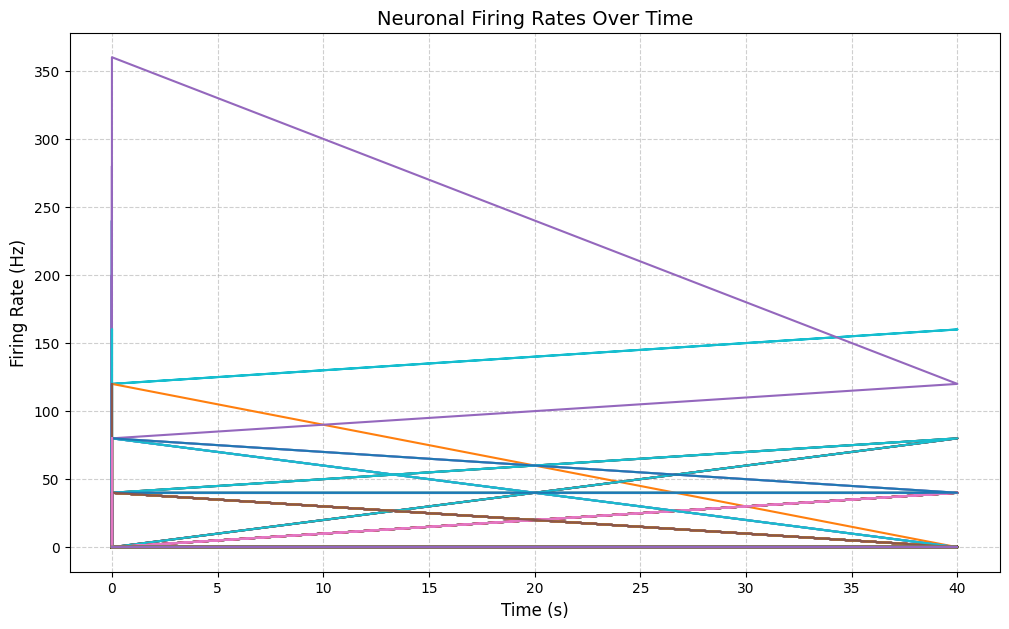

In [45]:
ts_axis = test[-1, :]

# Get all rows except the last one for the y-axis (neuron firing rates)
neuron_rates = test[:-1, :]


# --- 3. Create the Plot ---

# Set a good figure size
plt.figure(figsize=(12, 7))

# Loop through each row in the neuron_rates array
# Each row represents one neuron's activity over time
for i in range(neuron_rates.shape[0]):
    # Plot the timestamps (x-axis) against the firing rates of one neuron (y-axis)
    plt.plot(ts_axis, neuron_rates[i, :], label=f'Neuron {i+1}')

# Add labels and a title to make the plot informative
plt.xlabel("Time (s)", fontsize=12)
plt.ylabel("Firing Rate (Hz)", fontsize=12)
plt.title("Neuronal Firing Rates Over Time", fontsize=14)

# Add a legend to identify which line corresponds to which neuron
#plt.legend()

# Add a grid for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Display the plot
plt.show()